In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report

from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
data = pd.read_csv("dataset/milestone1.csv")
pd.set_option('display.max_columns', None)

In [3]:
ClassToNum = {
    'hospitalized' : 0,
    'nonhospitalized' : 1,
    'recovered' : 2,
    'deceased' : 3
}

NumToClass = {v: k for k, v in ClassToNum.items()}

labels = ['hospitalized', 'nonhospitalized', 'recovered', 'deceased']

## This function is adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html
def gs_result_plot(results, param_name, lb, ub, name):
    plt.figure(figsize=(10, 7))
    plt.title("GridSearchCV evaluation on " + param_name)

    plt.xlabel(param_name)
    plt.ylabel("Score")

    ax = plt.gca()
    ax.set_xlim(lb, ub)
    ax.set_ylim(0, 1)

    # Get the regular numpy array from the MaskedArray
    X_axis = np.array(results['param_'+param_name].data, dtype=float)

    for scorer, color in zip(sorted(scoring), ['g', 'k', 'red']):
        for sample, style in (('train', '--'), ('test', '-')):
            sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
            sample_score_std = results['std_%s_%s' % (sample, scorer)]
            ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                            sample_score_mean + sample_score_std,
                            alpha=0.1 if sample == 'test' else 0, color=color)
            ax.plot(X_axis, sample_score_mean, style, color=color,
                    alpha=1 if sample == 'test' else 0.7,
                    label="%s (%s)" % (scorer, sample))

        best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
        best_score = results['mean_test_%s' % scorer][best_index]

        # Plot a dotted vertical line at the best score for that scorer marked by x
        ax.plot([X_axis[best_index], ] * 2, [0, best_score],
                linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

        # Annotate the best score for that scorer
        ax.annotate("%0.2f" % best_score,
                    (X_axis[best_index], best_score + 0.005))

    plt.legend(loc="best")
    plt.grid(False)
    plt.savefig('results/'+name)
    plt.show()

## Convert categorical columns to numerical by Label Encoding

In [4]:
data['Province_State'] = data['Province_State'].astype('category').cat.codes
data['Country_Region'] = data['Country_Region'].astype('category').cat.codes
data['date_confirmation'] = data['date_confirmation'].astype('category').cat.codes
data['sex'] = data['sex'].astype('category').cat.codes
data = data.replace({"outcome": ClassToNum})

# 3.1 Hyperparameter tuning

## Split data into training and test datasets with ratio 0.75 : 0.25

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['outcome']), data['outcome'], test_size = 0.25)

## Tuning Model - Light GBM

In [13]:
# Metric used is overall recall and recall on deceased. 
scoring = {'Recall_deceased':make_scorer(recall_score, labels = [3], average = 'macro'),
           'Recall':make_scorer(recall_score, average = 'macro')}

metrics = ['Recall_deceased', 'Recall']
flag = 1 # 0 or 1, controls tuning for overall recall or recall on deceased only

### Tune parameters in category 1 and fit a model using best parameters found so far

In [43]:
param1 = {
        'boosting_type': ['gbdt', 'dart', 'goss', 'rf'], # dart for higher deceased recall, goss for higher overall recall
        'objective': ['multiclass'], # fixed 
        'class_weight': [None, 'balanced'], # balanced will improve recall of deceased class, and it is appropariate to problem
}
        
gs1 = GridSearchCV(LGBMClassifier(), param_grid=param1, scoring=scoring, n_jobs=4, cv = 5, 
                  refit=metrics[flag], return_train_score=True)
gs1.fit(X_train, y_train)

print(gs1.best_params_)
print(gs1.best_score_)

{'boosting_type': 'dart', 'class_weight': 'balanced', 'objective': 'multiclass'}
0.676984126984127


In [14]:
## Generate and store 2 best models after tuning category 1, to be used in tuning category 2

## Add model for best recall on deceased class
lgb_models = [LGBMClassifier(boosting_type = 'dart', objective = 'multiclass', class_weight = 'balanced')]
## Add model for best overall recall
lgb_models.append(LGBMClassifier(boosting_type = 'goss', objective = 'multiclass', class_weight = 'balanced'))

### Tune parameters in category 2 and fit 2 model using best parameters found so far

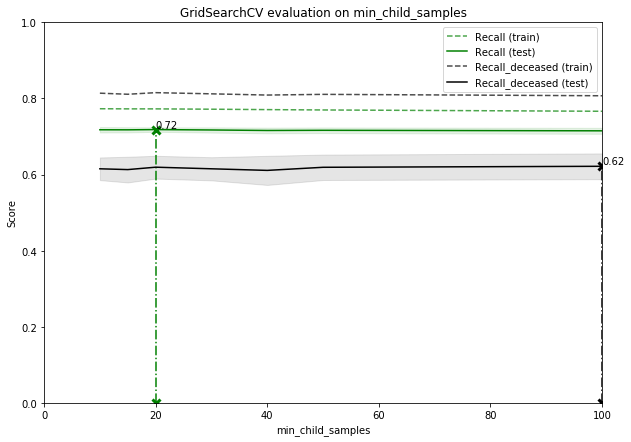

In [22]:
param2 = {
         'num_leaves': [10, 20, 50, 100, 150, 200], # 20 for higher deceased recall, 200 for overall recall
         'min_child_samples': [10, 15, 20, 30, 40, 50, 100], # 20 for best performance evaluated by both metrics
         'max_depth': [-1, 2, 4, 6, 8, 10, 20, 40], #  2 for higher deceased recall, -1 for overall recall
}

gs2 = GridSearchCV(lgb_models[flag], param_grid=param2, scoring=scoring, n_jobs=4, cv = 5, 
                  refit=metrics[flag], return_train_score=True)
gs2.fit(X_train, y_train)

print(gs2.best_params_)
print(gs2.best_score_)
gs_result_plot(gs2.cv_results_, 'min_child_samples', 0, 100, 'lgb_param_min_child_samples')

In [23]:
## Generate and store 2 best models after tuning category 1 and 2, to be used in tuning category 3

## Add model for best recall on deceased class
lgb_models = [LGBMClassifier(boosting_type = 'dart', objective = 'multiclass', class_weight = 'balanced',
                      num_leaves = 20, min_child_samples = 20, max_depth = 1)]
## Add model for best overall recall
lgb_models.append(LGBMClassifier(boosting_type = 'goss', objective = 'multiclass', class_weight = 'balanced',
                      num_leaves = 200, min_child_samples = 20, max_depth = -1))

### Tune parameters in category 3 and fit 2 model using best parameters found so far

{'learning_rate': 0.1, 'n_estimators': 100, 'subsample_for_bin': 200000}
0.7177800777198702


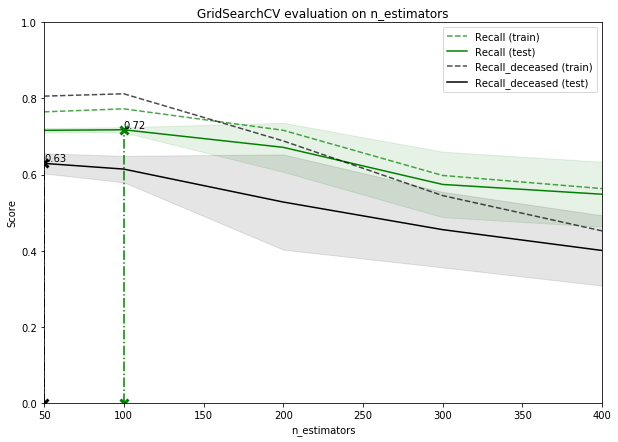

In [26]:
param3 = {
         'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
         'subsample_for_bin': [200000, 250000, 300000, 350000, 400000],
         'n_estimators': [50, 100, 200, 300, 400],
}

gs3 = GridSearchCV(lgb_models[flag], param_grid=param3, scoring=scoring, n_jobs=2, cv = 5, 
                  refit=metrics[flag], return_train_score=True)
gs3.fit(X_train, y_train)

print(gs3.best_params_)
print(gs3.best_score_)
gs_result_plot(gs3.cv_results_, 'n_estimators', 50, 400, 'lgb_param_n_estimators')

In [49]:
## Generate and store 2 best models after tuning category 1, 2, 3, to be used in performance analysis and comparative study 

## Add model for best recall on deceased class
lgb_models = [LGBMClassifier(boosting_type = 'dart', objective = 'multiclass', class_weight = 'balanced',
                      num_leaves = 20, min_child_samples = 20, max_depth = 2, learning_rate = 0.1, subsample_for_bin = 200000,
                            n_estimators = 100)]
## Add model for best overall recall
lgb_models.append(LGBMClassifier(boosting_type = 'goss', objective = 'multiclass', class_weight = 'balanced',
                      num_leaves = 200, min_child_samples = 20, max_depth = -1, learning_rate = 0.1, subsample_for_bin = 200000,
                            n_estimators = 100))

## Evaluate 2 LGB models using training dataset only

In [54]:
pred = lgb_models[0].fit(X_train, y_train).predict(X_train) ## model that uses deceased recall as refit metric
print(classification_report(y_train, pred, target_names=['0', '1', '2', '3']))

              precision    recall  f1-score   support

           0       0.83      0.29      0.42    147544
           1       1.00      1.00      1.00    119591
           2       0.50      0.49      0.50     70503
           3       0.03      0.68      0.05      3780

    accuracy                           0.58    341418
   macro avg       0.59      0.61      0.49    341418
weighted avg       0.81      0.58      0.64    341418



## The model that use overall recall as metric performs better than the other model

In [53]:
pred = lgb_models[1].fit(X_train, y_train).predict(X_train) ## model that uses overall recall as refit metric
print(classification_report(y_train, pred, target_names=['0', '1', '2', '3']))

              precision    recall  f1-score   support

           0       0.90      0.61      0.73    147544
           1       1.00      0.98      0.99    119591
           2       0.69      0.67      0.68     70503
           3       0.05      0.80      0.10      3780

    accuracy                           0.75    341418
   macro avg       0.66      0.76      0.62    341418
weighted avg       0.88      0.75      0.80    341418



## Tuning Model - KNN

In [6]:
scoring = {'Accuracy': make_scorer(accuracy_score), 
           'Overall Recall': make_scorer(recall_score, average='macro'), 
           'Recall on deceased': make_scorer(recall_score, labels=[ClassToNum['deceased']], average='macro')}

param_grid = {'n_neighbors': range(5, 40, 10), 'weights':['uniform', 'distance'], 'p':[1, 2]}

print('Grid Search on Accuracy Start')
gs_acc = GridSearchCV(KNeighborsClassifier(), 
        param_grid=param_grid, scoring=scoring, n_jobs=4, 
        refit='Accuracy', return_train_score=True).fit(X_train, y_train)

print('Grid Search on Overall Recall Start')
gs_recall = GridSearchCV(KNeighborsClassifier(), 
        param_grid=param_grid, scoring=scoring, n_jobs=4, 
        refit='Overall Recall', return_train_score=True).fit(X_train, y_train)

print('Grid Search on Deceased Recall Start')
gs_recall_deceased = GridSearchCV(KNeighborsClassifier(), 
        param_grid=param_grid, scoring=scoring, n_jobs=4, 
        refit='Recall on deceased', return_train_score=True).fit(X_train, y_train)


Grid Search on Accuracy Start
Grid Search on Overall Recall Start
Grid Search on Deceased Recall Start


ACC Result
best {'n_neighbors': 35, 'p': 1, 'weights': 'distance'}
Recall Result
best {'n_neighbors': 25, 'p': 1, 'weights': 'distance'}
Recall on deceased Result
best {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}


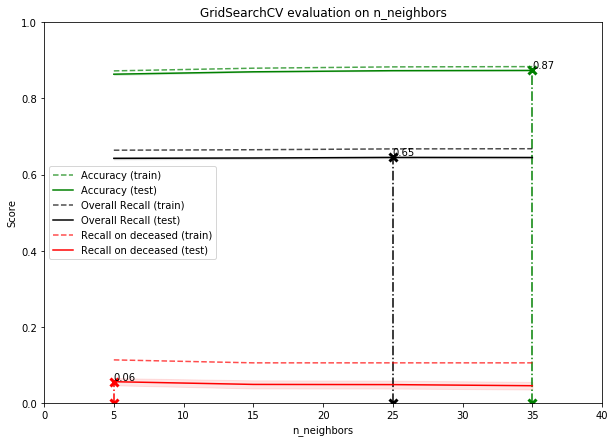

In [7]:
acc_results = gs_acc.cv_results_
print('ACC Result')
print('best', gs_acc.best_params_)

recall_results = gs_recall.cv_results_
print('Recall Result')
print('best', gs_recall.best_params_)

recall_deceased_results = gs_recall_deceased.cv_results_
print('Recall on deceased Result')
print('best', gs_recall_deceased.best_params_)

gs_result_plot(recall_deceased_results, 'n_neighbors', 0, 40, 'knn_param_n_neighbors')

## Accuracy as metric

In [55]:
knn_acc = KNeighborsClassifier(n_neighbors = 35, weights = 'distance', p = 1)
pred = knn_acc.fit(X_train, y_train).predict(X_train)
print(classification_report(y_train, pred, target_names=['0', '1', '2', '3']))

              precision    recall  f1-score   support

           0       0.82      0.94      0.88    147544
           1       1.00      1.00      1.00    119591
           2       0.82      0.61      0.70     70503
           3       1.00      0.10      0.19      3780

    accuracy                           0.88    341418
   macro avg       0.91      0.66      0.69    341418
weighted avg       0.88      0.88      0.87    341418



## Overall recall as metric

In [56]:
knn_overall_recall = KNeighborsClassifier(n_neighbors = 25, weights = 'distance', p = 1)
pred = knn_overall_recall.fit(X_train, y_train).predict(X_train)
print(classification_report(y_train, pred, target_names=['0', '1', '2', '3']))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87    147544
           1       1.00      1.00      1.00    119591
           2       0.79      0.62      0.70     70503
           3       1.00      0.10      0.19      3780

    accuracy                           0.88    341418
   macro avg       0.90      0.66      0.69    341418
weighted avg       0.88      0.88      0.87    341418



## Recall on deceased as metric

In [57]:
knn_dec_recall = KNeighborsClassifier(n_neighbors = 5, weights = 'distance', p = 1)
pred = knn_dec_recall.fit(X_train, y_train).predict(X_train)
print(classification_report(y_train, pred, target_names=['0', '1', '2', '3']))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86    147544
           1       1.00      1.00      1.00    119591
           2       0.73      0.65      0.69     70503
           3       0.93      0.11      0.19      3780

    accuracy                           0.87    341418
   macro avg       0.87      0.66      0.68    341418
weighted avg       0.87      0.87      0.87    341418



## All 3 KNN models have roughly equal recall on deceased class, but model 1 and 2 have higher precision. 
## Therefore we chose the second model which is the model using overall recall as metric

# 3.1 Comparative Study

In [23]:
best_lgb = lgb_models[1]
best_knn = knn_overall_recall

## Evaluate LGBM on test dataset

In [30]:
pred = best_lgb.predict(X_test)
print(classification_report(y_test, pred, target_names=['0', '1', '2', '3']))

              precision    recall  f1-score   support

           0       0.92      0.59      0.72     49152
           1       1.00      0.99      0.99     39964
           2       0.68      0.67      0.68     23472
           3       0.05      0.78      0.09      1218

    accuracy                           0.75    113806
   macro avg       0.66      0.76      0.62    113806
weighted avg       0.89      0.75      0.80    113806



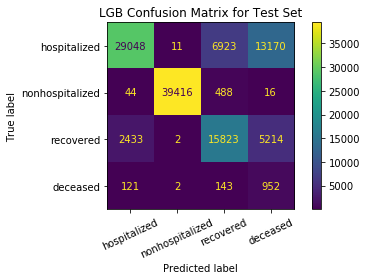

In [31]:
disp = plot_confusion_matrix(best_lgb, X_test, y_test, display_labels = labels, xticks_rotation = 25)
disp.ax_.set_title('LGB Confusion Matrix for Test Set')
plt.tight_layout()
plt.savefig('plots/lgb_cm_test.png')

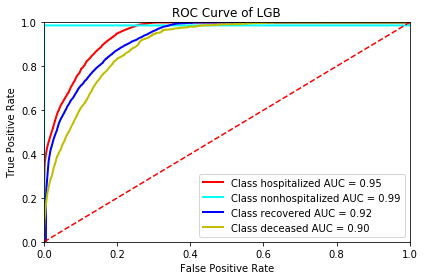

In [50]:
y_scores = best_lgb.predict_proba(X_test)
colors = ['r', 'aqua', 'b', 'y']

for i in range(4):
    y = []
    y[:] = [1 if x == i else 0 for x in y_test]

    fpr, tpr, threshold = roc_curve(y, y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, colors[i], linewidth=2, label = f'Class {NumToClass[i]} AUC = %0.2f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of LGB')
plt.tight_layout()
plt.savefig('plots/lgb_roc.png')
plt.show()

## Evaluate KNN on test dataset

In [34]:
pred = best_knn.predict(X_test)
print(classification_report(y_test, pred, target_names=['0', '1', '2', '3']))

              precision    recall  f1-score   support

           0       0.83      0.92      0.87     49152
           1       1.00      1.00      1.00     39964
           2       0.79      0.64      0.70     23472
           3       0.89      0.10      0.18      1218

    accuracy                           0.88    113806
   macro avg       0.88      0.66      0.69    113806
weighted avg       0.88      0.88      0.87    113806



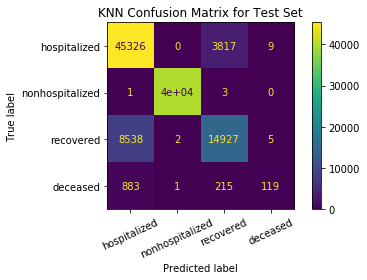

In [35]:
disp = plot_confusion_matrix(best_knn, X_test, y_test, display_labels = labels, xticks_rotation = 25)
disp.ax_.set_title('KNN Confusion Matrix for Test Set')
plt.tight_layout()
plt.savefig('plots/knn_cm_test.png')

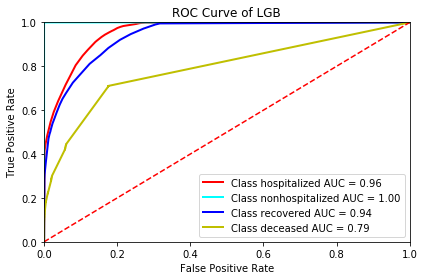

In [51]:
y_scores = best_knn.predict_proba(X_test)
colors = ['r', 'aqua', 'b', 'y']

for i in range(4):
    y = []
    y[:] = [1 if x == i else 0 for x in y_test]

    fpr, tpr, threshold = roc_curve(y, y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, colors[i], linewidth=2, label = f'Class {NumToClass[i]} AUC = %0.2f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of LGB')
plt.tight_layout()
plt.savefig('plots/knn_roc.png')
plt.show()